## Image Classification with CNN on flower species


This is a dataset containing 210 flower images grouped into 10 species, which is open to the public available at Kaggle:

(https://www.kaggle.com/olgabelitskaya/flower-color-images/home)


Through with a small sample size, it would be a nice start for my trial on building and exploring Convolutional Neural Network (CNN) at the fundamental level of image classification through artificial intelligence. The workout deployed Keras commonly for neural network implementations. To compromise the insufficiency in the number of samples, Keras provides *ImageDataGenerator()* function for manipulating the original images that can force more samples to be inputted during the training process.

CNN is a kind of network that applies different weighting filters (kernel matrix) sweeping across the pixel matrix, and produces reduced matrix size of heights and widths by matrix multiplications, while increasing the depth, defined as a convolution operation. This process would be speeded up by setting up pooling, i.e. taking the maximum, minimum, mean, or other kinds of aggregations. The pixel values extracted from the images would be used for a supervised classification task tied with their species labels. The goal is to assess the performance of the trained CNN in predicting the flower species shown in the pictures, and tuning parameters of the network.



In [0]:
!pip install imageio
!pip install torch

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import imageio
import torch
import os

from keras.models import Sequential
from keras.layers import Input
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras import backend as K
from keras.optimizers import SGD

Using TensorFlow backend.


In [0]:
## import data
from google.colab import files
files.upload()

Saving flower_images.zip to flower_images.zip


In [0]:
!unzip flower_images.zip

Archive:  flower_images.zip
   creating: flower_images/
  inflating: flower_images/.DS_Store  
   creating: flower_images/.ipynb_checkpoints/
  inflating: flower_images/0001.png  
  inflating: flower_images/0002.png  
  inflating: flower_images/0003.png  
  inflating: flower_images/0004.png  
  inflating: flower_images/0005.png  
  inflating: flower_images/0006.png  
  inflating: flower_images/0007.png  
  inflating: flower_images/0008.png  
  inflating: flower_images/0009.png  
  inflating: flower_images/0010.png  
  inflating: flower_images/0011.png  
  inflating: flower_images/0012.png  
  inflating: flower_images/0013.png  
  inflating: flower_images/0014.png  
  inflating: flower_images/0015.png  
  inflating: flower_images/0016.png  
  inflating: flower_images/0017.png  
  inflating: flower_images/0018.png  
  inflating: flower_images/0019.png  
  inflating: flower_images/0020.png  
  inflating: flower_images/0021.png  
  inflating: flower_images/0022.png  
  inflating: flower_im

### Pre-processing:

After extracting all the images in the folder, the following function was used to read the pixel values of each image into a list of arrays. The corresponding species class labels were read into another list. To further confirm and investigate the data, the list of image would be converted to numpy arrays and some images could be randomly selected for visualizations.

From the output, each image carried 3 dimensions, (128, 128, 4), which represented the pixel values of its height, width and the RGB color intensity. The values fell within the range of [0, 255], the last column was only for indicating this scale, and it would be discarded before inputting for modelling.


In [0]:
## image reading and gathering all images into a dataset
## Extracting target labels of plant species

from keras.preprocessing import image

def image_read(path, name):
  image_folder = os.path.join(path, 'flower_images/')
  image_path = os.path.join(image_folder, name)
  image = np.array(imageio.imread(image_path))
  return image

filepath = "./"
file = pd.read_csv(filepath + 'flower_images/flower_labels.csv')
image_list = list(file.iloc[:,0].values)
data = []
label = []
for i in range(0, len(image_list)):
  x = image_read(filepath, image_list[i])
  data.append(x)
  label.append(file.iloc[i,1])

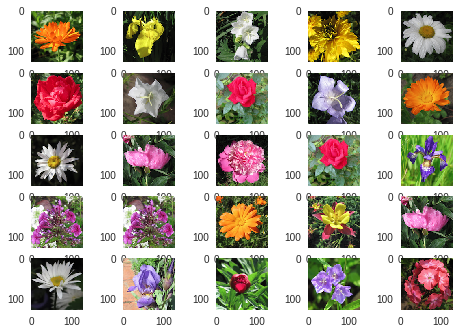

In [0]:
## Check & Visualize images read from the above function
f, ax = plt.subplots(ncols=5, nrows=5)

for i in range(5):
  for j in range(5):
    image = data[np.random.randint(0, len(data))]
    ax[i,j].imshow(image)
    ax[i,j].grid()

In [0]:
## Check data structure
data[209][0][0:10]

array([[ 23,  69,  13, 255],
       [ 26,  72,  15, 255],
       [ 33,  72,  22, 255],
       [ 32,  67,  22, 255],
       [ 29,  69,  22, 255],
       [ 31,  82,  28, 255],
       [ 35,  99,  30, 255],
       [ 51, 115,  37, 255],
       [ 65, 122,  43, 255],
       [ 71, 120,  42, 255]], dtype=uint8)

In [0]:
## Check label
label[0:10]

[0, 0, 2, 0, 0, 1, 6, 0, 0, 0]

### Split for training and testing:

Training images were randomly picked up from the dataset, performing a shuffling effect. It was explicit that X's were the input image pixels matices, while Y's were a single categorical vector. Here, the label Y vector would be broken down to a 10-dimensional matrix by one hot encoding, getting 1 for the correct class column and filling 0 for the others in the same row. Since the multiple classes of flower species did not possess ordinal characteristics, a vector of 1 to 10 factors seemed not to be a proper structure regarding the data inference.

For testing, 10% of the flower images would be held out and isolated from exposure to the learning process.


In [0]:
# Processing data for Convolutional Neural Network classification

## Define the splitting ratio
Train_size = int(210*0.9)
Test_size = int(210*0.1)
Train_X = data.copy()
Train_Y = label.copy()
Test_X = []
Test_Y = []

for i in range(Test_size):
  ## Shuffling the data for random sampling and splitting
  index = np.random.randint(0, len(Train_X))
  sample = data[index]
  species = label[index]
  ## Training and Testing data
  Test_X.append(sample)
  Test_Y.append(species)
  Train_X.pop(index)
  Train_Y.pop(index)

In [0]:
# Check the dimensions of the training set & testing set
## The data consist of 4 dimensions of arrays: 189 images, respecitvely with a height of 128 and width of 128, and a RGB color code in range(0,255)
np.array(Train_X).shape

(189, 128, 128, 4)

In [0]:
# Discard the 4th column that indicates the 255-coding range; and thus leaving 3 channels representing R,G,B layers
train_X = np.array(Train_X)[:,:,:,0:3]
test_X = np.array(Test_X)[:,:,:,0:3]
train_Y = np.array(Train_Y)
test_Y = np.array(Test_Y)

In [0]:
# One-hot encoding of labels
fill_zero_train = np.zeros((len(Train_Y), 10))
for i in range(len(Train_Y)):
  fill_zero_train[i, train_Y[i]] = 1
train_Y = fill_zero_train
fill_zero_test = np.zeros((len(Test_Y), 10))
for i in range(len(Test_Y)):
  fill_zero_test[i, test_Y[i]] = 1
test_Y = fill_zero_test

### Data Augmentation:

There were options to determine how to generate transformed or distorted images. The following setting considered re-scaling the pixel intensity values divided by 255 to get a range of [0, 1] for normalization. The image could be randomly rotated up to 90 degree, and it allowed shifting from the centering position, trimming, enlarging, and flipping by axes. 

To use the data generator, in the CNN fitting command, the configurations of "batch_size" and "steps_per_epoch" needed to be specified, such that the total number of images generated for training would be equal to: $batch \ size \times steps \ per \ epoch$

Therefore, batch size of 32 and 100 steps per epoch created 3200 images for training.


In [0]:
# Use ImageGenerator to generate more images for training in case the sample size is small
from keras.preprocessing.image import ImageDataGenerator
 
gen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip=True)

### Model training & results:

This layout set up 5 convolutional layers, with a maximum pooling layer floowing each convolution operation. ReLU activation was used in each layer accounting for non-linearity. 4 hidden layers were added on flattened data, the output layer consisted of 10 units activated by softmax function. The loss function for 10 mutually exlcusive class classification should be categorical cross entropy.

Training parameters could be tuned to facilitate better learning results. For example, at the beginning I only used 1 hidden layer before output activation, meanwhile attempted to use Dropout layer following each max-pooling layer that discarded some units to prevent overfitting to the training data, and selected the "Adam" optimizer, but it turned out that the loss function did not change with proceeding epochs. The learning rate might be too low as "Adam" set by default at 0.001 that the model could not converge or have a good generalization on the predictions. Then, "SGD" (stochastic gradient descent) was tested, the training loss kept declining yet at a very slow rate. I also removed the Dropout layer, increasing number of hidden layers, increasing learning rate to 0.1 or 0.01. 

The resulting training history can be referred to in the following. It was observed that the loss and accuracy started to change significantly and continuously improved after undergoing 15 to 25 epochs. With 50 epochs, the accuracy of training data was around 0.55, yet the accuracy on testing data was only 0.19, this might indicate possible overfitting and the number of epochs was not enough for learning performance. When the epochs increased to 100, both training and testing accuracy were close to 0.81, this showed an marked improvement.

While this was preliminary, re-running experiments adjusting hyper-parameters might get more satisfactory learning results.


In [0]:
# Construct the Convolutional Neural Network structure
def Convmodel():
  
  model = Sequential()
  
  # Down-sampling process: convolution to smaller sized pixel matrix and increasing the depth
  # speeding up down-sampling by taking aggregation at each level: maximum pooling layers

  model.add(Conv2D(8, (3, 3), padding='same', activation='relu', input_shape=(128, 128, 3)))
  model.add(Conv2D(8, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
  model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
  model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
  model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  
  sgd = SGD(lr=0.01, momentum=0.001, decay=0.001, nesterov=False)
  
  model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

  model.summary()
  
  return model

In [0]:
# fitting
model = Convmodel()
hist = model.fit_generator(gen.flow(train_X, train_Y, batch_size = 32), steps_per_epoch = 100, epochs = 50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 128, 128, 8)       224       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 128, 128, 8)       584       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 64, 64, 16)        1168      
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 64, 64, 16)        2320      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 32, 32, 32)        4640      
__________

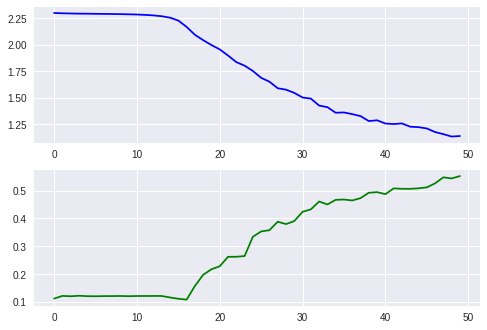

In [0]:
# plot training history
f, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b')
ax[1].plot(hist.history['acc'], color='g')

In [0]:
# evaluate on test data
model.evaluate(test_X, test_Y)

21/21 [==============================] - 0s 22ms/step


[13.047982215881348, 0.190476194024086]

In [0]:
# re-try with 100 epochs
model = Convmodel()
history = model.fit_generator(gen.flow(train_X, train_Y, batch_size = 32), steps_per_epoch = 100, epochs = 100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 128, 128, 8)       224       
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 128, 128, 8)       584       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 64, 64, 16)        1168      
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 64, 64, 16)        2320      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 32, 32, 32)        4640      
__________

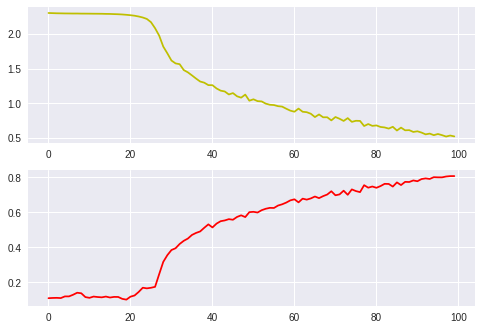

In [0]:
f, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='y')
ax[1].plot(history.history['acc'], color='r')

In [0]:
model.evaluate(test_X, test_Y)

21/21 [==============================] - 1s 29ms/step


[3.07011342048645, 0.8095238208770752]